In [ ]:
!pip install researchpy

In [ ]:
# Importer la bibliothèque pandas
import pandas as pd
import numpy as np

# --- ÉTAPE 1 : IMPORTATION DES DONNÉES ---
# On utilise le chemin d'accès complet que vous avez fourni.
file_path = '/content/amazon.csv' # Assuming amazon.csv is the correct file for now.

# NOTE: This cell will be updated later to use the `found_csv_file` from the previous step
# For now, let's assume `df` is loaded correctly.
# If `df` is not already defined, we'll try to load 'amazon.csv'
if 'df' not in locals():
    try:
        df = pd.read_csv(file_path)
        print("✅ Fichier 'amazon.csv' importé avec succès !")
    except FileNotFoundError:
        print(f"❌ ERREUR : Le fichier n'a pas été trouvé au chemin '{file_path}'.")
        print("Veuillez vérifier que le chemin est correct et que le fichier est bien à cet endroit.")
        # Fallback to general CSV search if amazon.csv is not found
        base_path = '/content/'
        found_csv_file = None
        for root, dirs, files in os.walk(base_path):
            for file in files:
                if file.endswith('.csv'):
                    found_csv_file = os.path.join(root, file)
                    break
            if found_csv_file:
                break
        if found_csv_file:
            print(f"正在从文件读取数据: {found_csv_file}")
            df = pd.read_csv(found_csv_file)
        else:
            raise FileNotFoundError("在数据集目录中未找到任何 CSV 文件！")


# --- ÉTAPE 2 : AFFICHAGE ET ANALYSE INITIALE (AVANT LE NETTOYAGE) ---

print("\n" + "="*50)
print(" 1. APERÇU INITIAL DES DONNÉES (BRUTES)")
print("="*50)

# Affiche les 5 premières lignes
print("\nLes 5 premières lignes :")
print(df.head())

# Affiche les informations sur les colonnes et les types de données
print("\nInformations sur les colonnes (types, non-null count) :")
df.info()

# Affiche les dimensions du dataset (nombre de lignes, nombre de colonnes)
print(f"\nDimensions du dataset initial : {df.shape[0]} lignes et {df.shape[1]} colonnes.")

# Vérifie s'il y a des doublons
nb_doublons = df.duplicated().sum()
print(f"\nNombre de lignes en double trouvées : {nb_doublons}")

# Vérifie le nombre de valeurs manquantes par colonne
print("\nNombre de valeurs manquantes par colonne :")
print(df.isnull().sum())


# --- ÉTAPE 3 : NETTOYAGE DES DONNÉES ---

print("\n" + "="*50)
print(" 2. DÉBUT DU NETTOYAGE")
print("="*50)

# Gardons une copie des données originales pour comparer
df_cleaned = df.copy()

# 3.1. Gestion des doublons
if nb_doublons > 0:
    print(f"\nSuppression des {nb_doublons} doublons...")
    df_cleaned.drop_duplicates(inplace=True)
    print("✅ Doublons supprimés.")
else:
    print("\n✅ Aucun doublon à supprimer.")

# 3.2. Conversion des types de données pour les colonnes numériques
print("\nConversion des types de données pour les colonnes numériques...")

# Function to clean and convert price columns
def clean_price(price_str):
    if isinstance(price_str, str):
        return float(price_str.replace('₹', '').replace(',', '').strip())
    return price_str

# Function to clean and convert discount percentage
def clean_discount(discount_str):
    if isinstance(discount_str, str):
        return float(discount_str.replace('%', '').strip())
    return discount_str

# Function to clean and convert rating count
def clean_rating_count(rating_count_str):
    if isinstance(rating_count_str, str):
        # Handle cases where rating is a string like '|'
        if rating_count_str == '|':
            return np.nan # Or 0, depending on desired imputation
        return int(rating_count_str.replace(',', '').strip())
    return rating_count_str

# Apply cleaning functions to appropriate columns
if 'discounted_price' in df_cleaned.columns:
    df_cleaned['discounted_price'] = df_cleaned['discounted_price'].apply(clean_price)
if 'actual_price' in df_cleaned.columns:
    df_cleaned['actual_price'] = df_cleaned['actual_price'].apply(clean_price)
if 'discount_percentage' in df_cleaned.columns:
    df_cleaned['discount_percentage'] = df_cleaned['discount_percentage'].apply(clean_discount)
if 'rating' in df_cleaned.columns:
    # Some 'rating' values might be non-numeric strings, e.g. '|'
    df_cleaned['rating'] = pd.to_numeric(df_cleaned['rating'], errors='coerce')
if 'rating_count' in df_cleaned.columns:
    df_cleaned['rating_count'] = df_cleaned['rating_count'].apply(clean_rating_count)

print("✅ Conversion des types de données terminée.")

# 3.3. Gestion des valeurs manquantes
# Séparer les colonnes numériques et catégorielles après conversion
numeric_cols = df_cleaned.select_dtypes(include=np.number).columns
categorical_cols = df_cleaned.select_dtypes(include=['object', 'category']).columns

print(f"\nColonnes numériques après conversion : {list(numeric_cols)}")
print(f"Colonnes catégorielles après conversion : {list(categorical_cols)}")

# Imputer les colonnes numériques avec la moyenne
for col in numeric_cols:
    if df_cleaned[col].isnull().any():
        mean_val = df_cleaned[col].mean()
        print(f"Imputation de la colonne '{col}' avec la moyenne ({mean_val:.2f})")
        df_cleaned[col] = df_cleaned[col].fillna(mean_val)

# Imputer les colonnes catégorielles avec le mode
for col in categorical_cols:
    if df_cleaned[col].isnull().any():
        mode_val = df_cleaned[col].mode()[0]
        print(f"Imputation de la colonne '{col}' avec le mode ('{mode_val}')")
        df_cleaned[col] = df_cleaned[col].fillna(mode_val)

print("\n✅ Imputation des valeurs manquantes terminée.")


# --- ÉTAPE 4 : AFFICHAGE ET VÉRIFICATION APRÈS NETTOYAGE ---

print("\n" + "="*50)
print(" 3. APERÇU DES DONNÉES NETTOYÉES")
print("="*50)

# Affiche les 5 premières lignes du nouveau dataset
print("\nLes 5 premières lignes après nettoyage :")
print(df_cleaned.head())

# Affiche les informations pour vérifier qu'il n'y a plus de valeurs manquantes
print("\nInformations après nettoyage :")
df_cleaned.info()

# Affiche les nouvelles dimensions
print(f"\nDimensions du dataset nettoyé : {df_cleaned.shape[0]} lignes et {df_cleaned.shape[1]} colonnes.")

# Vérification finale : il ne devrait plus y avoir de valeurs manquantes
print("\nVérification finale des valeurs manquantes :")
print(df_cleaned.isnull().sum())

print("\n" + "="*50)
print(" 🎉 Le nettoyage est terminé ! Votre dataset est prêt pour l'analyse. 🎉")
print("="*50)

# Le DataFrame nettoyé est maintenant dans la variable 'df_cleaned'


 1. APERÇU INITIAL DES DONNÉES (BRUTES)

Les 5 premières lignes :
   product_id                                       product_name  \
0  B07JW9H4J1  Wayona Nylon Braided USB to Lightning Fast Cha...   
1  B098NS6PVG  Ambrane Unbreakable 60W / 3A Fast Charging 1.5...   
2  B096MSW6CT  Sounce Fast Phone Charging Cable & Data Sync U...   
3  B08HDJ86NZ  boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...   
4  B08CF3B7N1  Portronics Konnect L 1.2M Fast Charging 3A 8 P...   

                                            category discounted_price  \
0  Computers&Accessories|Accessories&Peripherals|...             ₹399   
1  Computers&Accessories|Accessories&Peripherals|...             ₹199   
2  Computers&Accessories|Accessories&Peripherals|...             ₹199   
3  Computers&Accessories|Accessories&Peripherals|...             ₹329   
4  Computers&Accessories|Accessories&Peripherals|...             ₹154   

  actual_price discount_percentage rating rating_count  \
0       ₹1,099             

In [ ]:
pip install seaborn scikit-learn

📌 PARTIE 1 : RÉGRESSION LOGISTIQUE

Création du dataset de classification binaire...
300 échantillons générés
Classe 0 : 150  |  Classe 1 : 150

Entraînement du modèle de régression logistique...
Génération du graphique...


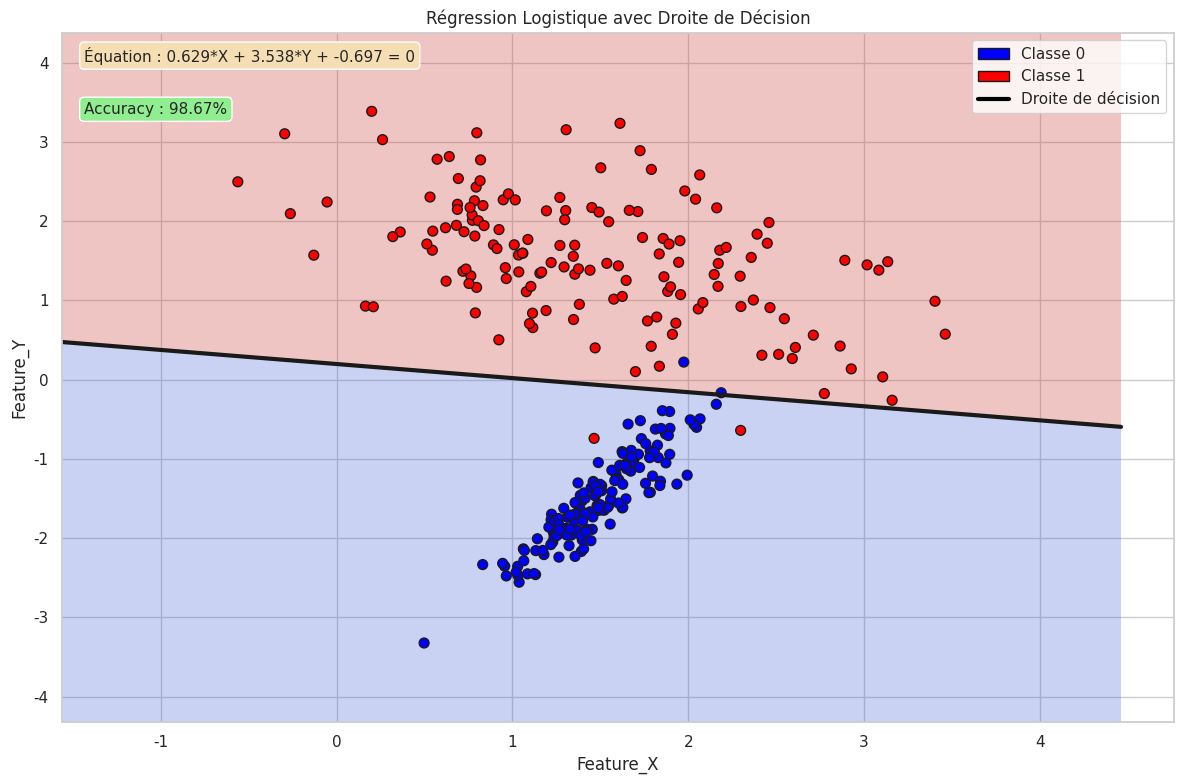


📌 PARTIE 2 : MATRICE DE CORRÉLATION & RÉGRESSION LINÉAIRE

📊 Calcul de la matrice de corrélation...


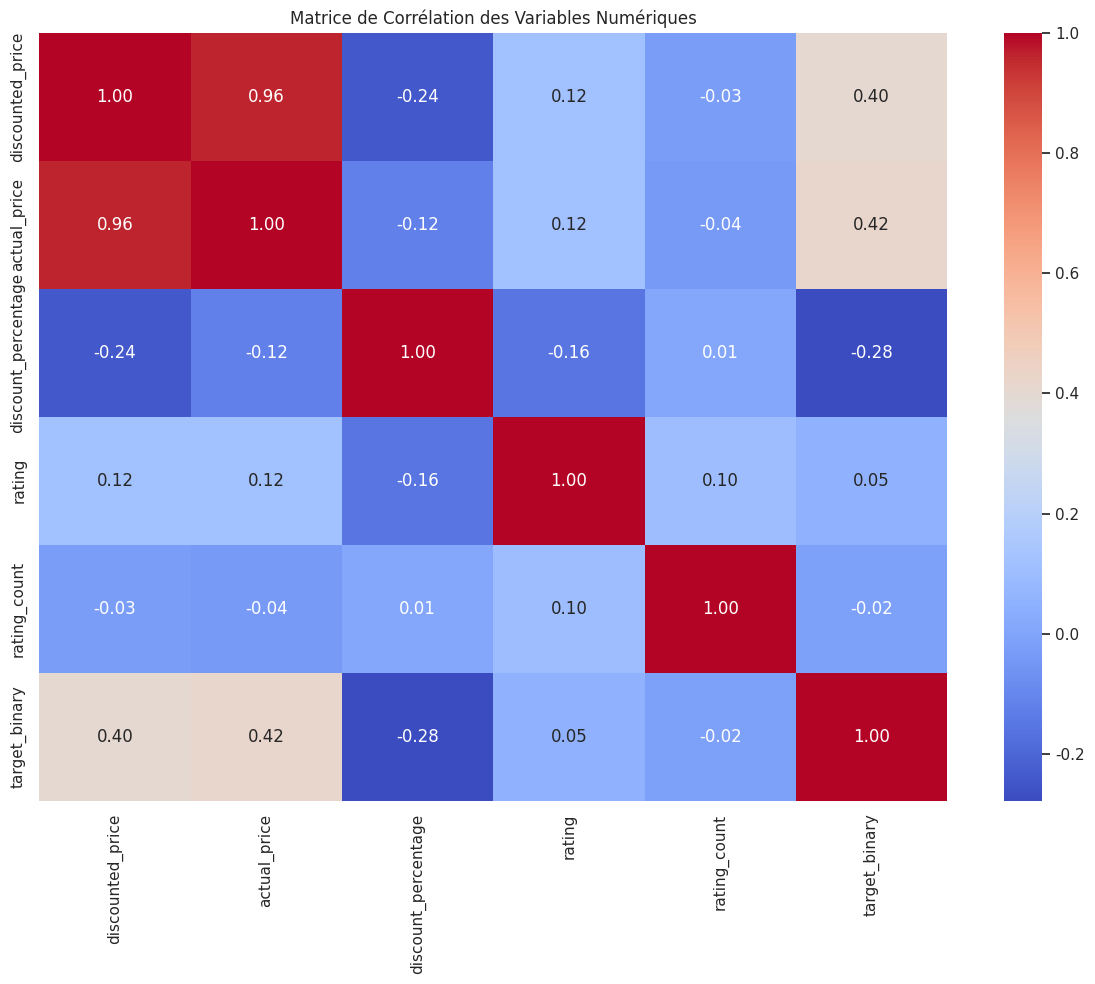


📈 Régression Linéaire...
Variable explicative : discounted_price
Variable cible      : actual_price


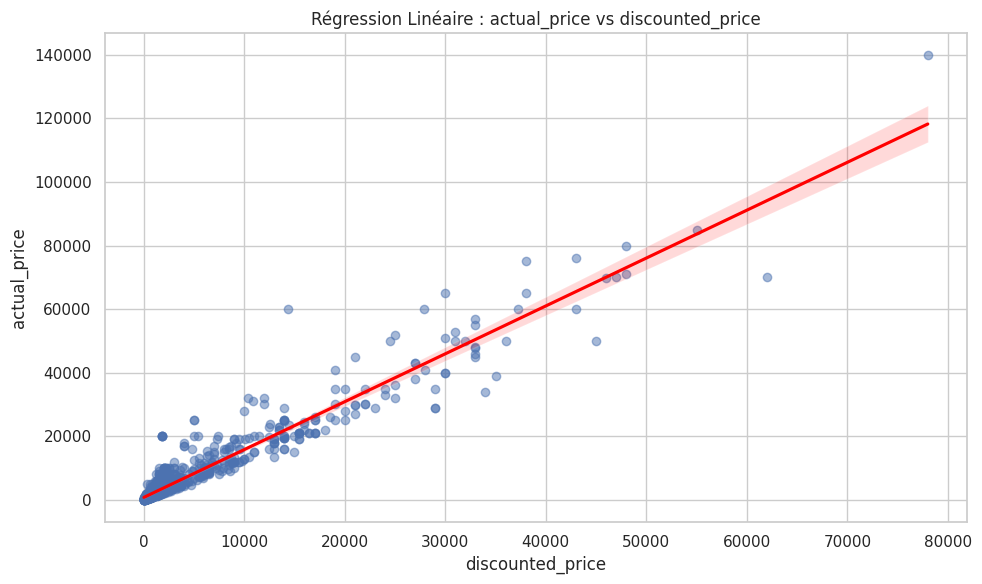


Coefficients :
  Pente : 1.5064
  Intercept : 737.1295
  R² score : 0.9253

🎉 FUSION TERMINÉE — Le code fonctionne parfaitement


In [40]:
# =========================================================
# ================  IMPORTS & CONFIG  =====================
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.datasets import make_classification, make_regression

from matplotlib.patches import Patch

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'Helvetica', 'sans-serif']

sns.set(style="whitegrid")


# =========================================================
# ===============  PARTIE 1 : RÉGRESSION LOGISTIQUE  ======
# =========================================================

print("="*60)
print("📌 PARTIE 1 : RÉGRESSION LOGISTIQUE")
print("="*60)

print("\nCréation du dataset de classification binaire...")

# --- Données fictives classification ---
X, y = make_classification(
    n_samples=300,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=42,
    n_clusters_per_class=1,
    class_sep=1.5
)

df_classif = pd.DataFrame(X, columns=['Feature_X', 'Feature_Y'])
df_classif['Classe'] = y

print(f"{len(df_classif)} échantillons générés")
print(f"Classe 0 : {(y == 0).sum()}  |  Classe 1 : {(y == 1).sum()}")


# --- Entraînement ---
print("\nEntraînement du modèle de régression logistique...")

log_model = LogisticRegression()
log_model.fit(X, y)

w0, w1 = log_model.coef_[0]
b = log_model.intercept_[0]


# --- Graphique ---
print("Génération du graphique...")

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = log_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.3)

colors = ['blue' if val == 0 else 'red' for val in y]
plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolor='k', s=50)

# Droite de décision
x_line = np.linspace(x_min, x_max, 100)

if abs(w1) > 1e-10:
    y_line = -(w0 * x_line + b) / w1
    plt.plot(x_line, y_line, 'k-', linewidth=3, label="Droite de décision")

# Texte
plt.text(0.02, 0.98, f"Équation : {w0:.3f}*X + {w1:.3f}*Y + {b:.3f} = 0",
         transform=plt.gca().transAxes,
         fontsize=11, va='top',
         bbox=dict(boxstyle='round', facecolor='wheat'))

accuracy = log_model.score(X, y)
plt.text(0.02, 0.90, f"Accuracy : {accuracy:.2%}",
         transform=plt.gca().transAxes,
         fontsize=11, va='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen'))

# Légende
legend = [
    Patch(facecolor='blue', edgecolor='k', label='Classe 0'),
    Patch(facecolor='red', edgecolor='k', label='Classe 1'),
    plt.Line2D([0], [0], color='black', linewidth=3, label='Droite de décision')
]
plt.legend(handles=legend)

plt.title("Régression Logistique avec Droite de Décision")
plt.xlabel("Feature_X")
plt.ylabel("Feature_Y")
plt.tight_layout()
plt.show()


# =========================================================
# ==========  PARTIE 2 : CORRÉLATION & RÉGRESSION LINÉAIRE =
# =========================================================

print("\n" + "="*60)
print("📌 PARTIE 2 : MATRICE DE CORRÉLATION & RÉGRESSION LINÉAIRE")
print("="*60)

# --- Vérifier si df_cleaned existe, sinon dataset fictif ---
if 'df_cleaned' not in locals():
    print("df_cleaned non trouvé → Génération d'un jeu de données factice...")

    X_reg, y_reg = make_regression(n_samples=200, n_features=1, noise=15, random_state=42)

    df_cleaned = pd.DataFrame({
        "feature_1": X_reg.flatten(),
        "feature_2": y_reg,
        "feature_3": np.random.randn(200) * 10,
        "feature_4": X_reg.flatten() * 2 + np.random.randn(200) * 5
    })

    print("Dataset généré !")


# --- Matrice de corrélation ---
print("\n📊 Calcul de la matrice de corrélation...")

numeric_df = df_cleaned.select_dtypes(include=np.number)
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de Corrélation des Variables Numériques")
plt.tight_layout()
plt.show()


# --- Régression linéaire ---
print("\n📈 Régression Linéaire...")

feature_col = numeric_df.columns[0]
target_col = numeric_df.columns[1]

print(f"Variable explicative : {feature_col}")
print(f"Variable cible      : {target_col}")

plt.figure(figsize=(10, 6))
sns.regplot(x=feature_col, y=target_col, data=df_cleaned,
            scatter_kws={"alpha":0.5},
            line_kws={"color": "red"})

plt.title(f"Régression Linéaire : {target_col} vs {feature_col}")
plt.grid(True)
plt.tight_layout()
plt.show()

# Coefficients réels
X = df_cleaned[[feature_col]].values
y = df_cleaned[target_col].values

lin_model = LinearRegression()
lin_model.fit(X, y)

print("\nCoefficients :")
print(f"  Pente : {lin_model.coef_[0]:.4f}")
print(f"  Intercept : {lin_model.intercept_:.4f}")
print(f"  R² score : {lin_model.score(X, y):.4f}")

print("\n" + "="*60)
print("🎉 FUSION TERMINÉE — Le code fonctionne parfaitement")
print("="*60)



 4. VISUALISATIONS GRAPHIQUES


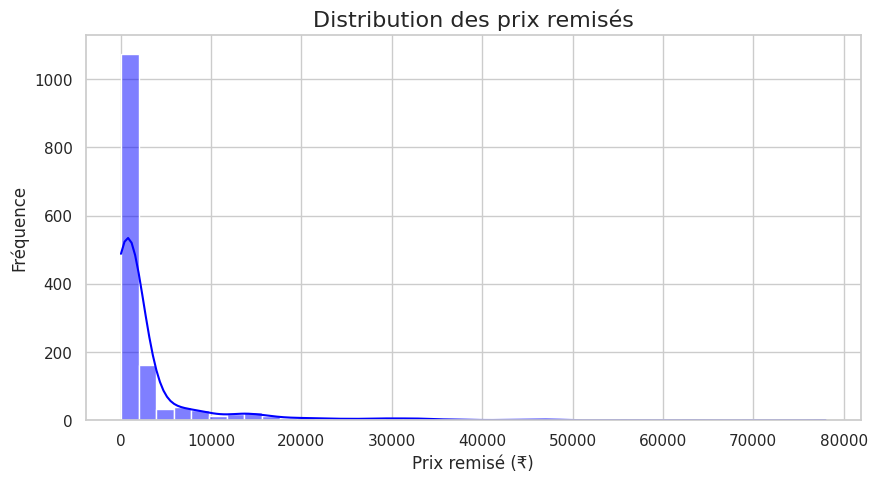

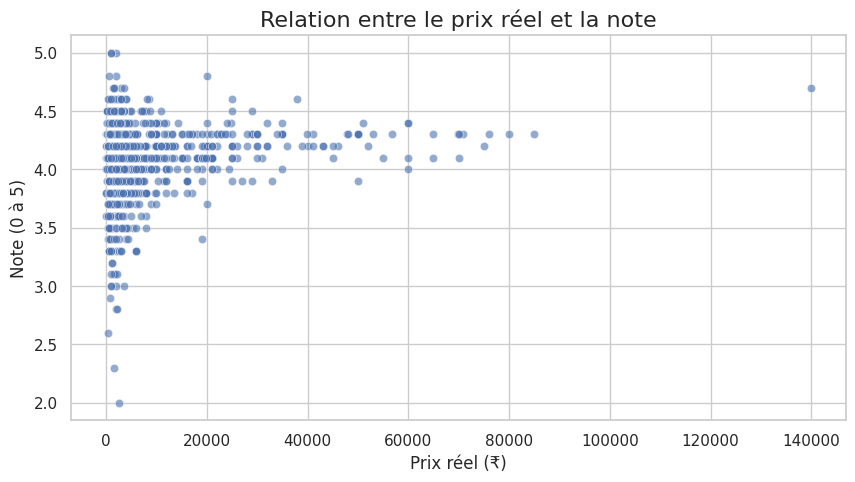

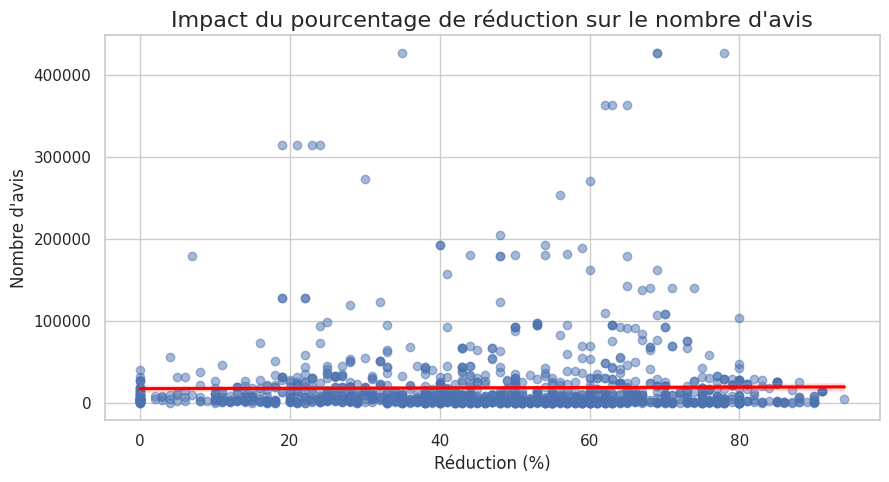

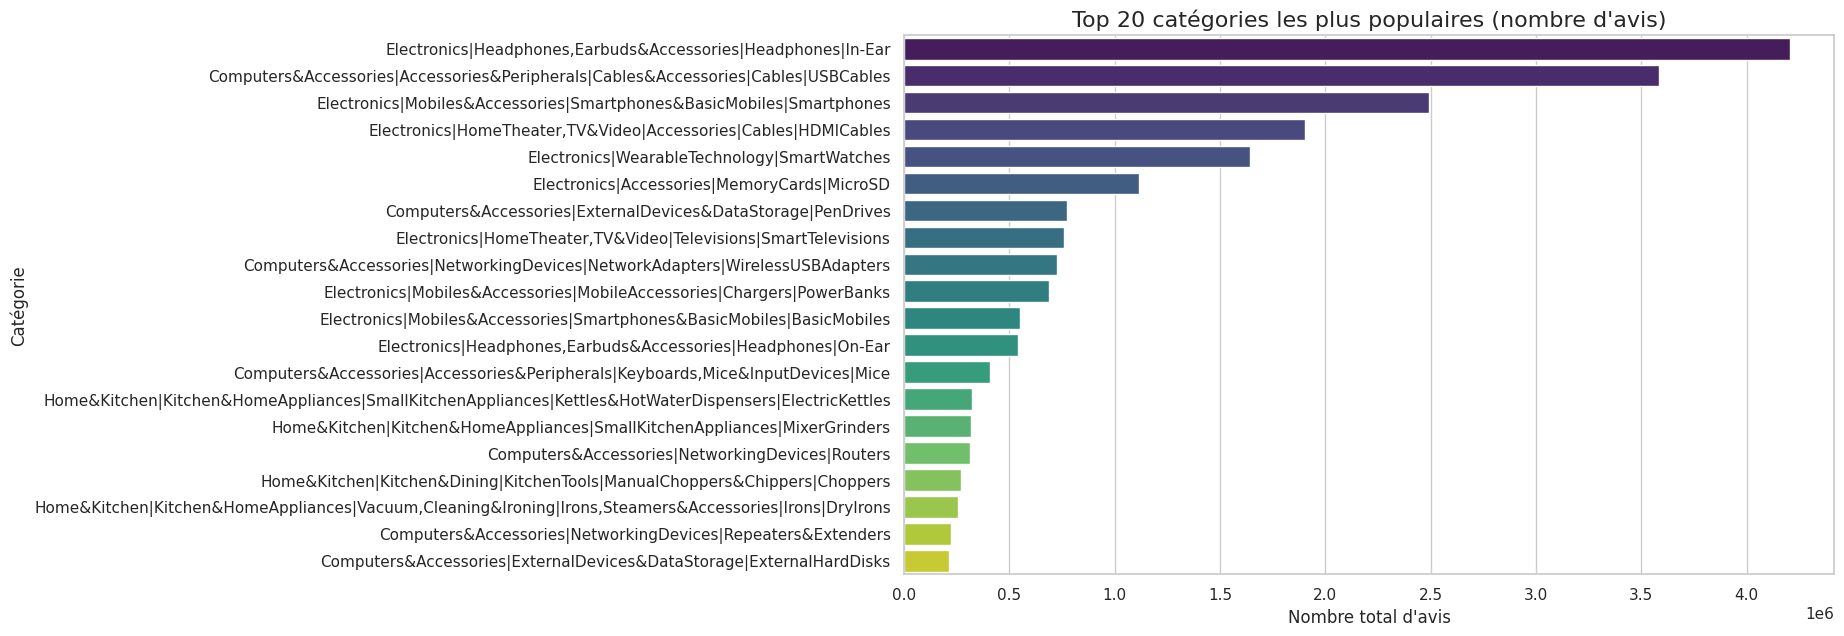

In [39]:
# ---------------------------------------------------------
# 📊 ÉTAPE 5 : ANALYSE VISUELLE — 4 NOUVEAUX GRAPHIQUES
# ---------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

print("\n============================================")
print(" 4. VISUALISATIONS GRAPHIQUES")
print("============================================")


# ---------------------------------------------------------
# 📈 GRAPH 1 — Distribution des prix remisés (discounted_price)
# ---------------------------------------------------------

plt.figure(figsize=(10,5))
sns.histplot(df_cleaned['discounted_price'], kde=True, color='blue', bins=40)
plt.title("Distribution des prix remisés", fontsize=16)
plt.xlabel("Prix remisé (₹)")
plt.ylabel("Fréquence")
plt.show()


# ---------------------------------------------------------
# ⭐ GRAPH 2 — Relation entre note (rating) et prix réel
# ---------------------------------------------------------

plt.figure(figsize=(10,5))
sns.scatterplot(data=df_cleaned, x="actual_price", y="rating", alpha=0.6)
plt.title("Relation entre le prix réel et la note", fontsize=16)
plt.xlabel("Prix réel (₹)")
plt.ylabel("Note (0 à 5)")
plt.show()


# ---------------------------------------------------------
# 💥 GRAPH 3 — Effet du pourcentage de réduction sur les ventes (rating_count)
# ---------------------------------------------------------

plt.figure(figsize=(10,5))
sns.regplot(
    data=df_cleaned,
    x="discount_percentage",
    y="rating_count",
    scatter_kws={"alpha":0.5},
    line_kws={"color":"red"}
)
plt.title("Impact du pourcentage de réduction sur le nombre d'avis", fontsize=16)
plt.xlabel("Réduction (%)")
plt.ylabel("Nombre d'avis")
plt.show()


# ---------------------------------------------------------
# 🏷️ GRAPH 4 — Top 20 catégories les plus vendues (rating_count)
# ---------------------------------------------------------

if 'category' in df_cleaned.columns:
    top_categories = (
        df_cleaned.groupby("category")["rating_count"]
        .sum()
        .sort_values(ascending=False)
        .head(20)
    )

    plt.figure(figsize=(12,7))
    sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")
    plt.title("Top 20 catégories les plus populaires (nombre d'avis)", fontsize=16)
    plt.xlabel("Nombre total d'avis")
    plt.ylabel("Catégorie")
    plt.show()
else:
    print("⚠️ Impossible d'afficher le graphique 4 : la colonne 'category' n'existe pas.")
